In [ ]:
import os
import random

import numpy as np
import torch

def configure_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def load_dataset(data_path, bias=False):
    data = np.load(data_path)

    train_X = data["train_images"].reshape([data["train_images"].shape[0], -1])/256
    dev_X = data["val_images"].reshape([data["val_images"].shape[0], -1])/256
    test_X = data["test_images"].reshape([data["test_images"].shape[0], -1])/256

    train_y = np.asarray(data["train_labels"]).squeeze()
    dev_y = np.asarray(data["val_labels"]).squeeze()
    test_y = np.asarray(data["test_labels"]).squeeze()

    if bias:
        train_X = np.hstack((train_X, np.ones((train_X.shape[0], 1))))
        dev_X = np.hstack((dev_X, np.ones((dev_X.shape[0], 1))))
        test_X = np.hstack((test_X, np.ones((test_X.shape[0], 1))))

    return {
        "train": (train_X, train_y), "dev": (dev_X, dev_y), "test": (test_X, test_y),
    }

class ClassificationDataset(torch.utils.data.Dataset):

    def __init__(self, data):
        """
        data: the dict returned by utils.load_pneumonia_data
        """
        train_X, train_y = data["train"]
        dev_X, dev_y = data["dev"]
        test_X, test_y = data["test"]

        self.X = torch.tensor(train_X, dtype=torch.float32)
        self.y = torch.tensor(train_y, dtype=torch.long)

        self.dev_X = torch.tensor(dev_X, dtype=torch.float32)
        self.dev_y = torch.tensor(dev_y, dtype=torch.long)

        self.test_X = torch.tensor(test_X, dtype=torch.float32)
        self.test_y = torch.tensor(test_y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
#!/usr/bin/env python

# Deep Learning Homework 1

import argparse

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from matplotlib import pyplot as plt

import time



In [ ]:



class LogisticRegression(nn.Module):

    def __init__(self, n_classes, n_features, **kwargs):
        """
        n_classes (int)
        n_features (int)

        The __init__ should be used to declare what kind of layers and other
        parameters the module has. For example, a logistic regression module
        has a weight matrix and bias vector. For an idea of how to use
        pytorch to make weights and biases, have a look at
        https://pytorch.org/docs/stable/nn.html
        """
        super().__init__()

        self.weights = nn.Parameter(torch.randn(n_features, n_classes) * 0.01)
        self.bias = nn.Parameter(torch.zeros(n_classes))

    def forward(self, x, **kwargs):
        """
        x (batch_size x n_features): a batch of training examples

        Every subclass of nn.Module needs to have a forward() method. forward()
        describes how the module computes the forward pass. In a log-lineear
        model like this, for example, forward() needs to compute the logits
        y = Wx + b, and return y (you don't need to worry about taking the
        softmax of y because nn.CrossEntropyLoss does that for you).

        One nice thing about pytorch is that you only need to define the
        forward pass -- this is enough for it to figure out how to do the
        backward pass.
        """


        return x @ self.weights+ self.bias



class FeedforwardNetwork(nn.Module):
    def __init__(
            self, n_classes, n_features, hidden_size, layers,
            activation_type, dropout, **kwargs):
        """
        n_classes (int)
        n_features (int)
        hidden_size (int)
        layers (int)
        activation_type (str)
        dropout (float): dropout probability

        As in logistic regression, the __init__ here defines a bunch of
        attributes that each FeedforwardNetwork instance has. Note that nn
        includes modules for several activation functions and dropout as well.
        """
        super().__init__()


        self.layers = nn.ModuleList()

        for i in range(layers):
            if i == 0:
                self.layers.append(nn.Linear(n_features, hidden_size))
            else:
                self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.output = nn.Linear(hidden_size, n_classes)

        self.dropout = nn.Dropout(dropout)

        if activation_type == 'relu':
            self.activation = nn.ReLU()
        elif activation_type == 'tanh':
            self.activation = nn.Tanh()





    def forward(self, x, **kwargs):
        """
        x (batch_size x n_features): a batch of training examples

        This method needs to perform all the computation needed to compute
        the output logits from x. This will include using various hidden
        layers, pointwise nonlinear functions, and dropout.
        """
        for layer in self.layers:
            x = self.activation(layer(x))
            x = self.dropout(x)
        return self.output(x)


def train_batch(X, y, model, optimizer, criterion, **kwargs):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    model: a PyTorch defined model
    optimizer: optimizer used in gradient step
    criterion: loss function

    To train a batch, the model needs to predict outputs for X, compute the
    loss between these predictions and the "gold" labels y using the criterion,
    and compute the gradient of the loss with respect to the model parameters.

    Check out https://pytorch.org/docs/stable/optim.html for examples of how
    to use an optimizer object to update the parameters.

    This function should return the loss (tip: call loss.item()) to get the
    loss as a numerical value that is not part of the computation graph.
    """

    optimizer.zero_grad()  # Limpa gradientes acumulados de iteracoes anteriores
    output = model(X)  #forward pass
    loss = criterion(output, y) #loss function/cross entropy
    loss.backward() #loss backward
    optimizer.step()  #recalculo do peso
    return loss.item()  #retorna a perda como um valor numérico



def predict(model, X):
    """X (n_examples x n_features)"""
    scores = model(X)  # (n_examples x n_classes)
    predicted_labels = scores.argmax(dim=-1)  # (n_examples)
    return predicted_labels


@torch.no_grad()
def evaluate(model, X, y, criterion):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    """
    model.eval()
    logits = model(X)
    loss = criterion(logits, y)
    loss = loss.item()
    y_hat = logits.argmax(dim=-1)
    n_correct = (y == y_hat).sum().item()
    n_possible = float(y.shape[0])
    model.train()
    return loss, n_correct / n_possible


def plot(epochs, plottables, filename=None, ylim=None):
    """Plot the plottables over the epochs.

    Plottables is a dictionary mapping labels to lists of values.
    """
    plt.clf()
    plt.xlabel('Epoch')
    for label, plottable in plottables.items():
        plt.plot(epochs, plottable, label=label)
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    if filename:
        plt.savefig(filename, bbox_inches='tight')





initial val acc: 0.1652
Training epoch 1
train loss: 1.5601 | val loss: 1.4736 | val acc: 0.4316
Training epoch 2
train loss: 1.3996 | val loss: 1.4046 | val acc: 0.4594
Training epoch 3
train loss: 1.3495 | val loss: 1.3561 | val acc: 0.4829
Training epoch 4
train loss: 1.3230 | val loss: 1.3557 | val acc: 0.4815
Training epoch 5
train loss: 1.3056 | val loss: 1.3335 | val acc: 0.4915
Training epoch 6
train loss: 1.2931 | val loss: 1.3191 | val acc: 0.4922
Training epoch 7
train loss: 1.2822 | val loss: 1.3312 | val acc: 0.4872
Training epoch 8
train loss: 1.2748 | val loss: 1.2988 | val acc: 0.5157
Training epoch 9
train loss: 1.2668 | val loss: 1.2982 | val acc: 0.5157
Training epoch 10
train loss: 1.2601 | val loss: 1.2888 | val acc: 0.5171
Training epoch 11
train loss: 1.2561 | val loss: 1.2923 | val acc: 0.5085
Training epoch 12
train loss: 1.2503 | val loss: 1.2830 | val acc: 0.5185
Training epoch 13
train loss: 1.2456 | val loss: 1.2834 | val acc: 0.5256
Training epoch 14
train

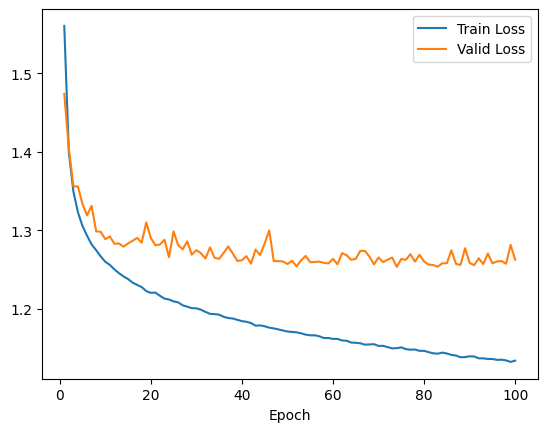

In [ ]:
def main():

    # parser = argparse.ArgumentParser()
    # parser.add_argument('model',
    #                     choices=['logistic_regression', 'mlp'],
    #                     default='logistic_regression',
    #                     help="Which model should the script run?")
    # parser.add_argument('-epochs', default=200, type=int,
    #                     help="""Number of epochs to train for. You should not
    #                     need to change this value for your plots.""")
    # parser.add_argument('-batch_size', default=64, type=int,
    #                     help="Size of training batch.")
    # parser.add_argument('-hidden_size', type=int, default=200)
    # parser.add_argument('-layers', type=int, default=2)
    # parser.add_argument('-learning_rate', type=float, default=0.002)
    # parser.add_argument('-l2_decay', type=float, default=0.0)
    # parser.add_argument('-dropout', type=float, default=0.3)
    # parser.add_argument('-momentum', type=float, default=0.0)
    # parser.add_argument('-activation',
    #                     choices=['tanh', 'relu'], default='relu')
    # parser.add_argument('-optimizer',
    #                     choices=['sgd', 'adam'], default='sgd')
    # parser.add_argument('-data_path', type=str, default='intel_landscapes.npz',)

    #opt = parser.parse_args()
    opt = {
        'model': 'logistic_regression',
        'epochs': 100,
        'batch_size': 32,
        'hidden_size': 200,
        'layers': 2,
        'learning_rate': 0.001,
        'l2_decay': 0.01,
        'dropout': 0.3,
        'momentum': 0.0,
        'activation': 'relu',
        'optimizer': 'sgd',
        'data_path': '/content/sample_data/intel_landscapes.v2.npz',
    }

    configure_seed(seed=42)

    data = load_dataset(opt['data_path'])
    dataset = ClassificationDataset(data)
    train_dataloader = DataLoader(
        dataset, batch_size=opt['batch_size'], shuffle=True, generator=torch.Generator().manual_seed(42))
    dev_X, dev_y = dataset.dev_X, dataset.dev_y
    test_X, test_y = dataset.test_X, dataset.test_y

    n_classes = torch.unique(dataset.y).shape[0]  # 10
    n_feats = dataset.X.shape[1]

    # initialize the model
    if opt['model'] == 'logistic_regression':
        model = LogisticRegression(n_classes, n_feats)
    else:
        model = FeedforwardNetwork(
            n_classes,
            n_feats,
            opt['hidden_size'],
            opt['layers'],
            opt['activation'],
            opt['dropout']
        )

    # get an optimizer
    optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}

    optim_cls = optims[opt['optimizer']]
    optimizer = optim_cls(
        model.parameters(), lr=opt['learning_rate'], weight_decay=opt['l2_decay'], momentum = opt['momentum']
    )

    # get a loss criterion
    criterion = nn.CrossEntropyLoss()

    # training loop
    epochs = torch.arange(1, opt['epochs'] + 1)
    train_losses = []
    valid_losses = []
    valid_accs = []

    start = time.time()

    print('initial val acc: {:.4f}'.format(evaluate(model, dev_X, dev_y, criterion)[1]))

    for ii in epochs:
        print('Training epoch {}'.format(ii))
        epoch_train_losses = []
        for X_batch, y_batch in train_dataloader:
            loss = train_batch(
                X_batch, y_batch, model, optimizer, criterion)
            epoch_train_losses.append(loss)

        epoch_train_loss = torch.tensor(epoch_train_losses).mean().item()
        val_loss, val_acc = evaluate(model, dev_X, dev_y, criterion)

        print('train loss: {:.4f} | val loss: {:.4f} | val acc: {:.4f}'.format(
            epoch_train_loss, val_loss, val_acc
        ))

        train_losses.append(epoch_train_loss)
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)

    elapsed_time = time.time() - start
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print('Training took {} minutes and {} seconds'.format(minutes, seconds))

    _, test_acc = evaluate(model, test_X, test_y, criterion)
    print('Final test acc: {:.4f}'.format(test_acc))

    # plot
    if opt['model'] == "logistic_regression":
        config = (
            f"batch-{opt['batch_size']}-lr-{opt['learning_rate']}-epochs-{opt['epochs']}-"
            f"l2-{opt['l2_decay']}-opt-{opt['optimizer']}"
        )
    else:
        config = (
            f"batch-{opt['batch_size']}-lr-{opt['learning_rate']}-epochs-{opt['epochs']}-"
            f"hidden-{opt['hidden_size']}-dropout-{opt['dropout']}-l2-{opt['l2_decay']}-"
            f"layers-{opt['layers']}-act-{opt['activation']}-opt-{opt['optimizer']}-mom-{opt['momentum']}"
        )

    losses = {
        "Train Loss": train_losses,
        "Valid Loss": valid_losses,
    }


    plot(epochs, losses, filename=f"{opt['model']}-training-loss-{config}.pdf")
    #accuracy = { "Valid Accuracy": valid_accs }
    #plot(epochs, accuracy, filename=f"{opt['model']}-validation-accuracy-{config}.pdf")
    # Plot the results
    #plot_results(epochs, train_losses, valid_losses, valid_accs, config, opt)




if __name__ == '__main__':
    main()

# Nova secção

initial val acc: 0.1645
Training epoch 1
train loss: 1.7894 | val loss: 1.7798 | val acc: 0.2044
Training epoch 2
train loss: 1.7791 | val loss: 1.7725 | val acc: 0.2308
Training epoch 3
train loss: 1.7729 | val loss: 1.7672 | val acc: 0.2286
Training epoch 4
train loss: 1.7679 | val loss: 1.7624 | val acc: 0.2322
Training epoch 5
train loss: 1.7640 | val loss: 1.7578 | val acc: 0.2379
Training epoch 6
train loss: 1.7578 | val loss: 1.7528 | val acc: 0.2415
Training epoch 7
train loss: 1.7544 | val loss: 1.7480 | val acc: 0.2436
Training epoch 8
train loss: 1.7505 | val loss: 1.7434 | val acc: 0.2429
Training epoch 9
train loss: 1.7450 | val loss: 1.7385 | val acc: 0.2443
Training epoch 10
train loss: 1.7404 | val loss: 1.7337 | val acc: 0.2464
Training epoch 11
train loss: 1.7366 | val loss: 1.7288 | val acc: 0.2507
Training epoch 12
train loss: 1.7304 | val loss: 1.7236 | val acc: 0.2543
Training epoch 13
train loss: 1.7243 | val loss: 1.7184 | val acc: 0.2621
Training epoch 14
train

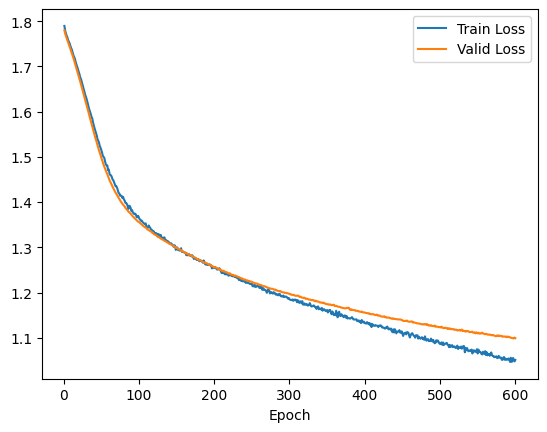

In [ ]:
def main():

    # parser = argparse.ArgumentParser()
    # parser.add_argument('model',
    #                     choices=['logistic_regression', 'mlp'],
    #                     default='logistic_regression',
    #                     help="Which model should the script run?")
    # parser.add_argument('-epochs', default=200, type=int,
    #                     help="""Number of epochs to train for. You should not
    #                     need to change this value for your plots.""")
    # parser.add_argument('-batch_size', default=64, type=int,
    #                     help="Size of training batch.")
    # parser.add_argument('-hidden_size', type=int, default=200)
    # parser.add_argument('-layers', type=int, default=2)
    # parser.add_argument('-learning_rate', type=float, default=0.002)
    # parser.add_argument('-l2_decay', type=float, default=0.0)
    # parser.add_argument('-dropout', type=float, default=0.3)
    # parser.add_argument('-momentum', type=float, default=0.0)
    # parser.add_argument('-activation',
    #                     choices=['tanh', 'relu'], default='relu')
    # parser.add_argument('-optimizer',
    #                     choices=['sgd', 'adam'], default='sgd')
    # parser.add_argument('-data_path', type=str, default='intel_landscapes.npz',)

    #opt = parser.parse_args()
    opt = {
        'model': 'mlp',
        'epochs': 600,
        'batch_size': 512,
        'hidden_size': 200,
        'layers': 2,
        'learning_rate': 0.002,
        'l2_decay': 0.0,
        'dropout': 0.3,
        'momentum': 0.0,
        'activation': 'relu',
        'optimizer': 'sgd',
        'data_path': '/content/sample_data/intel_landscapes.v2.npz',
    }

    configure_seed(seed=42)

    data = load_dataset(opt['data_path'])
    dataset = ClassificationDataset(data)
    train_dataloader = DataLoader(
        dataset, batch_size=opt['batch_size'], shuffle=True, generator=torch.Generator().manual_seed(42))
    dev_X, dev_y = dataset.dev_X, dataset.dev_y
    test_X, test_y = dataset.test_X, dataset.test_y

    n_classes = torch.unique(dataset.y).shape[0]  # 10
    n_feats = dataset.X.shape[1]

    # initialize the model
    if opt['model'] == 'logistic_regression':
        model = LogisticRegression(n_classes, n_feats)
    else:
        model = FeedforwardNetwork(
            n_classes,
            n_feats,
            opt['hidden_size'],
            opt['layers'],
            opt['activation'],
            opt['dropout']
        )

    # get an optimizer
    optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}

    optim_cls = optims[opt['optimizer']]
    optimizer = optim_cls(
        model.parameters(), lr=opt['learning_rate'], weight_decay=opt['l2_decay'], momentum = opt['momentum']
    )

    # get a loss criterion
    criterion = nn.CrossEntropyLoss()

    # training loop
    epochs = torch.arange(1, opt['epochs'] + 1)
    train_losses = []
    valid_losses = []
    valid_accs = []

    start = time.time()

    print('initial val acc: {:.4f}'.format(evaluate(model, dev_X, dev_y, criterion)[1]))

    for ii in epochs:
        print('Training epoch {}'.format(ii))
        epoch_train_losses = []
        for X_batch, y_batch in train_dataloader:
            loss = train_batch(
                X_batch, y_batch, model, optimizer, criterion)
            epoch_train_losses.append(loss)

        epoch_train_loss = torch.tensor(epoch_train_losses).mean().item()
        val_loss, val_acc = evaluate(model, dev_X, dev_y, criterion)

        print('train loss: {:.4f} | val loss: {:.4f} | val acc: {:.4f}'.format(
            epoch_train_loss, val_loss, val_acc
        ))

        train_losses.append(epoch_train_loss)
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)

    elapsed_time = time.time() - start
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print('Training took {} minutes and {} seconds'.format(minutes, seconds))

    _, test_acc = evaluate(model, test_X, test_y, criterion)
    print('Final test acc: {:.4f}'.format(test_acc))

    # plot
    if opt['model'] == "logistic_regression":
        config = (
            f"batch-{opt['batch_size']}-lr-{opt['learning_rate']}-epochs-{opt['epochs']}-"
            f"l2-{opt['l2_decay']}-opt-{opt['optimizer']}"
        )
    else:
        config = (
            f"batch-{opt['batch_size']}-lr-{opt['learning_rate']}-epochs-{opt['epochs']}-"
            f"hidden-{opt['hidden_size']}-dropout-{opt['dropout']}-l2-{opt['l2_decay']}-"
            f"layers-{opt['layers']}-act-{opt['activation']}-opt-{opt['optimizer']}-mom-{opt['momentum']}"
        )

    losses = {
        "Train Loss": train_losses,
        "Valid Loss": valid_losses,
    }


    plot(epochs, losses, filename=f"{opt['model']}-training-loss-{config}.pdf")
    #accuracy = { "Valid Accuracy": valid_accs }
    #plot(epochs, accuracy, filename=f"{opt['model']}-validation-accuracy-{config}.pdf")
    # Plot the results
    #plot_results(epochs, train_losses, valid_losses, valid_accs, config, opt)




if __name__ == '__main__':
    main()